### Lab 10 - PRAMOD KUNJUKUNJU SAJI - 8856432

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand.

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.

In [593]:
# Importing necessary libraries
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow import keras

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc


In [594]:
# List the folders in the dataset
folders = {'train':'archive/train', 'test':'archive/test', 'valid':'archive/valid'}

In [595]:
# Initialize image count dictionary
image_count = {}

# Dictionary to store image count for each class
def count_images(dir_path):
    folder = os.scandir(dir_path)
    files = 0
    for path in folder:
        if path.is_file():
            files += 1
    return files

# Dictionary to store image count for each class
def find_file_count_for_classes(dir_path):
    for folder in os.scandir(dir_path):
        if folder.is_dir():
            folder_name = folder
            image_count[folder_name] = count_images(folder.path)

# Find image count for each class in train folder
find_file_count_for_classes(folders['train'])

# Sort in descending order
img_count_sorted = sorted(image_count.items(), key=lambda item: item[1], reverse=True)

# Print top 3 classes with highest image count
top_3_classes = img_count_sorted[:3]

# Initialize list to store top 3 classes
top_3_classes_list = []

# Set top 3 classes in list
for image_name, count in top_3_classes:
    top_3_classes_list.append(str(image_name).split(" '")[1].replace("'>",""))

# Print top 3 classes
print(top_3_classes_list)

['RUFOUS TREPE', 'HOUSE FINCH', 'OVENBIRD']


In [596]:
# Remove the folders that are not in the top 3 classes
def remove_folder(dir_path):
    for entry in os.scandir(dir_path):
        if entry.is_dir() and entry.name not in top_3_classes_list:
                # Recursively call the function to remove the files inside
                shutil.rmtree(dir_path+'/'+entry.name)


# Call the method to remove the folders
for folder in list(folders.values()):
    remove_folder(folder)

2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [597]:
# Set up the data
train_dataset = image_dataset_from_directory(
    folders['train'],
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    folders['valid'],
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    folders['test'],
    image_size=(180, 180),
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 15 files belonging to 3 classes.


In [598]:
# Initializing augmented data generators
augmented_data = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# Initializing train generators
train_generator = augmented_data.flow_from_directory(
    folders['train'],
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Initializing validation generators
validation_generator = augmented_data.flow_from_directory(
    folders['valid'],
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Initializing test generators
test_generator = augmented_data.flow_from_directory(
    folders['test'],
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


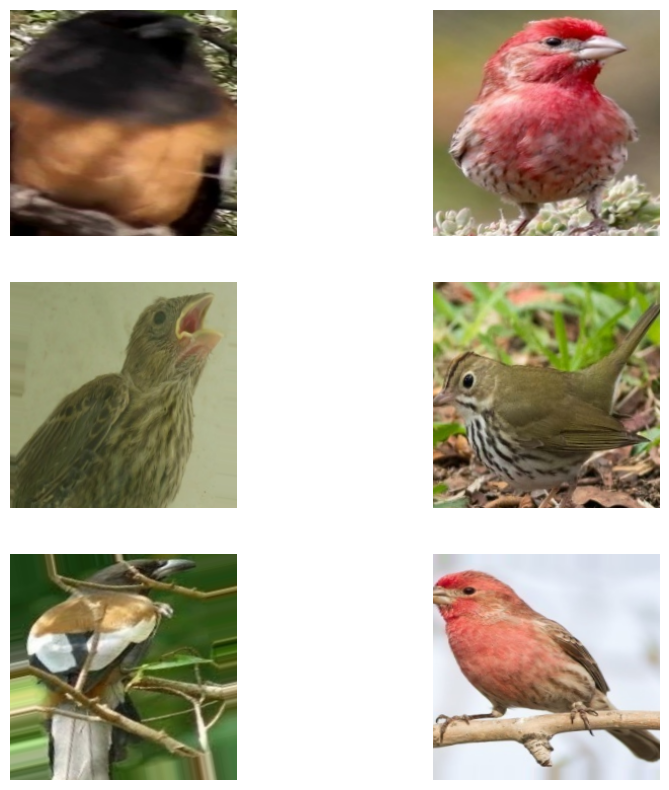

In [599]:
# Displaying first 6 augmented images
image, _ = next(train_generator)
plt.figure(figsize=(10,10))

for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    plt.imshow(image[i].astype('uint8'))
    plt.axis('off')
plt.show()

3.  Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [600]:
# Get VGG16 model with imagenet weights
org_VGG16_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# Print summary
org_VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [601]:
# Method to preprocess the images as features and labels
def get_features_and_labels(dataset):
    # Initialize the feature and label lists
    all_features = []
    all_labels = []

    # Iterate over the dataset and extract the features and labels
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = org_VGG16_model.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

    # Return the features and labels as numpy arrays
    return np.concatenate(all_features), np.concatenate(all_labels)

# Get the features and labels for the training, validation and test datasets
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 207ms/step


2023-08-07 22:36:12.904035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 162ms/step


2023-08-07 22:36:17.025870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


In [602]:
# Set all layers of the original VGG16 model to be non-trainable
for layer in org_VGG16_model.layers:
    layer.trainable = False

# Define the input layer with shape (224, 224, 3)
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass the inputs through the original VGG16 model up to the last layer before the fully connected layers
x = org_VGG16_model(inputs)

# Add a GlobalAveragePooling2D layer to convert the feature map to a 1D vector
x = layers.GlobalAveragePooling2D()(x)

# Add a Dense layer with 512 units and ReLU activation function
x = layers.Dense(512, activation='relu')(x)

# Add a Dropout layer with a dropout rate of 0.5 to prevent overfitting
x = layers.Dropout(0.5)(x)

# Add the final Dense layer with 3 units and softmax activation for multi-class classification
outputs = layers.Dense(3, activation='softmax')(x)

# Create the custom model using the specified inputs and outputs
custom_model = tf.keras.Model(inputs, outputs)

# Print the summary of the custom model to see the architecture
custom_model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_68 (Dense)            (None, 512)               262656    
                                                                 
 dropout_34 (Dropout)        (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 3)                 1539      
                                                          

In [603]:
# Compile the custom_model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using fit() method with the train_generator as the training data.
validation_data_run = custom_model.fit(train_generator, epochs=15, validation_data=validation_generator)

Epoch 1/15


2023-08-07 22:36:17.943498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 3.8199 - accuracy: 0.7151

2023-08-07 22:36:23.729325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 6s 243ms/step - loss: 3.8199 - accuracy: 0.7151 - val_loss: 0.3550 - val_accuracy: 0.9333
Epoch 2/15
24/24 [==============================] - 5s 222ms/step - loss: 1.2761 - accuracy: 0.8884 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 3/15
24/24 [==============================] - 5s 221ms/step - loss: 0.4398 - accuracy: 0.9543 - val_loss: 0.1662 - val_accuracy: 0.9333
Epoch 4/15
24/24 [==============================] - 5s 221ms/step - loss: 0.4451 - accuracy: 0.9637 - val_loss: 2.2570e-06 - val_accuracy: 1.0000
Epoch 5/15
24/24 [==============================] - 5s 221ms/step - loss: 0.3161 - accuracy: 0.9624 - val_loss: 2.5484e-04 - val_accuracy: 1.0000
Epoch 6/15
24/24 [==============================] - 6s 224ms/step - loss: 0.2721 - accuracy: 0.9758 - val_loss: 0.1520 - val_accuracy: 0.9333
Epoch 7/15
24/24 [==============================] - 5s 222ms/step - loss: 0.3677 - accuracy: 0.9570 - val_loss: 0.1805 - val_accuracy: 0.9333
Epoch 8/1

4.  Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

In [604]:
# Get the details to plot the accuracy and loss for the training and validation data
accuracy = validation_data_run.history["accuracy"]
validation_accuracy = validation_data_run.history["val_accuracy"]
loss = validation_data_run.history["loss"]
validation_loss = validation_data_run.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

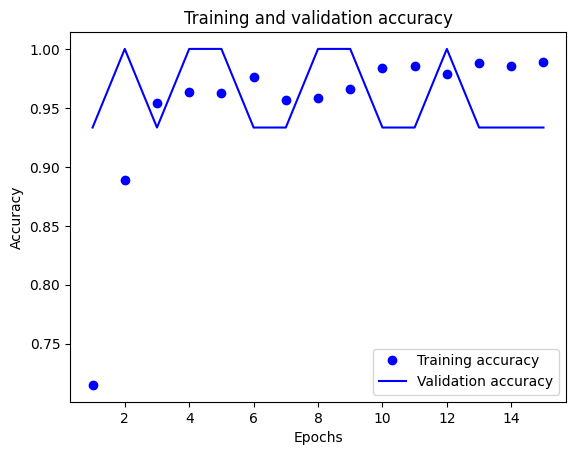

In [605]:
# Plot training and validation accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, validation_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

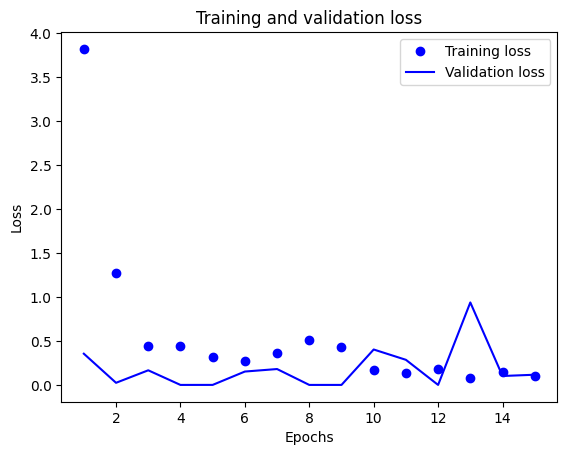

In [606]:
# Plot training and validation loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, validation_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [607]:
validation_model_loss, validation_model_acc = custom_model.evaluate(validation_generator)
print(f'Validation model loss: {validation_model_loss}')
print(f'Validation model accuracy: {validation_model_acc}')

1/1 [==============================] - 0s 210ms/step - loss: 0.0850 - accuracy: 0.9333
Validation model loss: 0.08501751720905304
Validation model accuracy: 0.9333333373069763


In [608]:
# Get test predictions
test_predictions = custom_model.predict(test_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Precision, Recall, and F1-Score
precision = precision_score(test_labels, test_predictions_classes, average='macro')
recall = recall_score(test_labels, test_predictions_classes, average='macro')
f1 = f1_score(test_labels, test_predictions_classes, average='macro')

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions_classes)
# Print test accuracy
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions_classes)

# Print confusion matrix
print(f"Confusion Matrix:\n {cm}")

# Print precision
print(f"Precision: {precision}")

# Print precision
print(f"Recall: {recall}")

# Print F1 score
print(f"F1 score: {f1}")

# Calculate classification report
class_report = classification_report(test_labels, test_predictions_classes, target_names=train_dataset.class_names)

# Print classification report
print(f"Classification Report:\n {class_report}")

1/1 [==============================] - 0s 232ms/step


2023-08-07 22:37:41.533939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Accuracy: 0.4
Confusion Matrix:
 [[1 2 2]
 [1 3 1]
 [3 0 2]]
Precision: 0.4000000000000001
Recall: 0.4000000000000001
F1 score: 0.4000000000000001
Classification Report:
               precision    recall  f1-score   support

 HOUSE FINCH       0.20      0.20      0.20         5
    OVENBIRD       0.60      0.60      0.60         5
RUFOUS TREPE       0.40      0.40      0.40         5

    accuracy                           0.40        15
   macro avg       0.40      0.40      0.40        15
weighted avg       0.40      0.40      0.40        15



AUC

HOUSE FINCH: 0.5247619047619048
OVENBIRD: 0.3589393939393939
RUFOUS TREPE: 0.34023809523809523


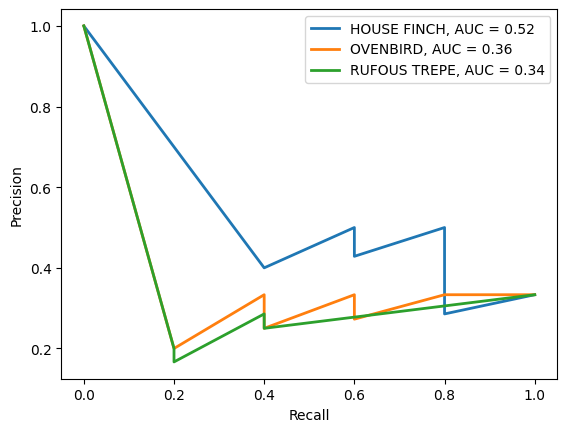

In [609]:
# Convert categorical values to one-hot encoding
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

print('AUC\n')
# Calculate precision-recall curve
for i in range(3):
    # Get the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    # Calculate the area under the curve
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'{class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# Plot the precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


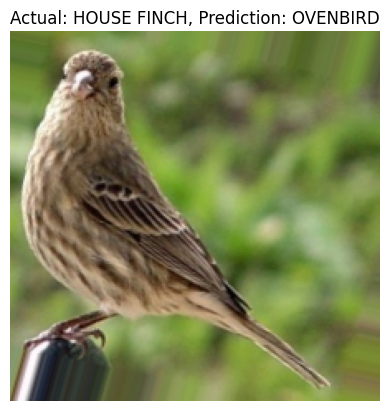

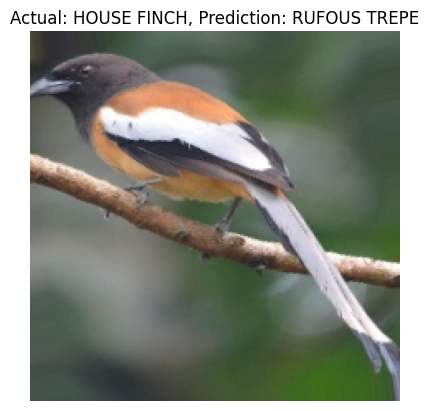

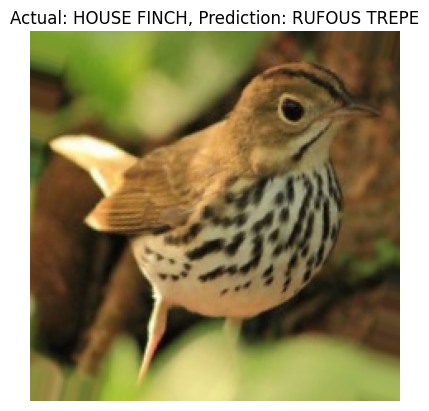

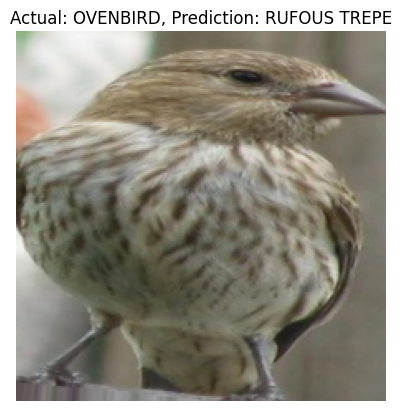

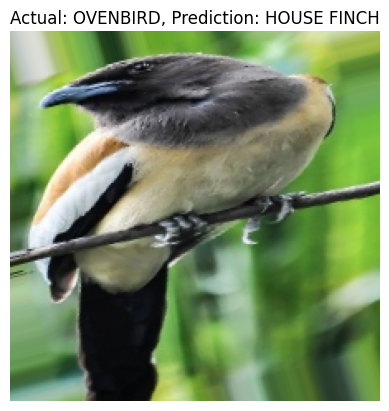

In [610]:
# Get failed test cases
misclassfied_index = np.where(y_pred_class != y_true)[0]
# Plot the first 5 misclassified images
for index in misclassfied_index[:5]:
    # Get the image batch
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    # Get the image
    img = img_batch[index % validation_generator.batch_size]
    
    # Get the true and predicted classes
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    # Plot the image
    plt.imshow(img.astype('uint8'))
    plt.title(f'Actual: {true_class_name}, Prediction: {predicted_class_name}')
    plt.axis('off')
    plt.show()
